In [1]:
import pandas as pd 
import numpy as np
import warnings

warnings.filterwarnings(action='ignore')

### 데이터 불러오기 

In [3]:
cust_tr = pd.read_csv('cust_train.csv', encoding = 'utf-8') # 회원
product_tr = pd.read_csv('product_train.csv',encoding = 'utf-8') # 상품구매
search_tr = pd.read_csv('search_train.csv',encoding = 'utf-8') # 검색어
session_tr = pd.read_csv('session_train.csv',encoding = 'utf-8') # 세션

In [4]:
cust_te = pd.read_csv('sample_submission.csv', encoding = 'utf-8')
product_te = pd.read_csv('product_test.csv',encoding = 'utf-8')
search_te = pd.read_csv('search_test.csv',encoding = 'utf-8')
session_te = pd.read_csv('session_test.csv',encoding = 'utf-8')

In [5]:
master = pd.read_csv('master.csv', encoding = 'utf-8') # 상품분류

### 데이터 전처리

In [6]:
train = pd.merge(product_tr, session_tr, on = ['CLNT_ID','SESS_ID'])
train = pd.merge(train, search_tr, on = ['CLNT_ID','SESS_ID'])
train = pd.merge(train, master, on = 'PD_C')

In [7]:
test = pd.merge(product_te, session_te, on = ['CLNT_ID','SESS_ID'])
test = pd.merge(test, search_te, on = ['CLNT_ID','SESS_ID'])
test = pd.merge(test, master, on = 'PD_C')

In [8]:
train['PD_BUY_AM'] = train['PD_BUY_AM'].map(lambda x: int(str(x).replace(',','')) )
train['PD_BUY_CT'] = train['PD_BUY_CT'].map(lambda x: int(str(x).replace(',','')) )
test['PD_BUY_AM'] = test['PD_BUY_AM'].map(lambda x: int(str(x).replace(',','')) )
test['PD_BUY_CT'] = test['PD_BUY_CT'].map(lambda x: int(str(x).replace(',','')) )

- 상품 1개당 금액과 구매수량을 int 타입으로 바꿈

### feature 생성

In [9]:
features = []
features_te = []

**[총구매액, 구매건수, 평균구매액, 최대구매액]**

In [10]:
train['AMOUNT'] = train['PD_BUY_AM'] * train['PD_BUY_CT']
test['AMOUNT'] = test['PD_BUY_AM'] * test['PD_BUY_CT']

- 한 사람이 구매한 총 금액을  알기 위해 추가

In [11]:
f = train.groupby('CLNT_ID')['AMOUNT'].agg([('총구매액', np.sum),
                                            ('구매건수', np.size),
                                            ('평균구매액', lambda x : np.round(np.mean(x))),
                                            ('최대구매액', np.max)]).reset_index()
features.append(f);display(f)

f_te = test.groupby('CLNT_ID')['AMOUNT'].agg([('총구매액', np.sum),
                                            ('구매건수', np.size),
                                            ('평균구매액', lambda x : np.round(np.mean(x))),
                                            ('최대구매액', np.max)]).reset_index()
features_te.append(f_te) ; display(f_te)

,CLNT_ID,총구매액,구매건수,평균구매액,최대구매액
0,0,86500,2,43250,81000
1,1,1276000,16,79750,99000
2,2,560000,11,50909,62100
3,3,851200,8,106400,110400
4,4,125200,6,20867,37000
...,...,...,...,...,...
263099,263099,973000,112,8688,22000
263100,263100,22400,2,11200,12900
263101,263101,135600,4,33900,33900
263102,263102,59400,15,3960,9720


,CLNT_ID,총구매액,구매건수,평균구매액,최대구매액
0,263104,31600,3,10533,13800
1,263105,314000,4,78500,120000
2,263106,49800,2,24900,29900
3,263107,88000,2,44000,49000
4,263108,124000,1,124000,124000
...,...,...,...,...,...
112755,375859,80000,3,26667,35000
112756,375860,902800,12,75233,149000
112757,375861,91800,2,45900,45900
112758,375862,92000,4,23000,23000


**[주말방문비율]**

In [12]:
train['date'] = pd.to_datetime(train['SESS_DT'], format= '%Y%m%d')

In [13]:
test['date'] = pd.to_datetime(test['SESS_DT'], format= '%Y%m%d')

- 구매일자를 datetime 타입으로 변형

In [14]:
f = train.groupby('CLNT_ID')['date'].agg([
    ('주말방문비율', lambda x: np.mean(x.dt.dayofweek>4))]).reset_index()
features.append(f); display(f)

f_te = test.groupby('CLNT_ID')['date'].agg([
    ('주말방문비율', lambda x: np.mean(x.dt.dayofweek>4))]).reset_index()
features_te.append(f_te);display(f_te)

,CLNT_ID,주말방문비율
0,0,1.000000
1,1,0.125000
2,2,0.000000
3,3,1.000000
4,4,0.333333
...,...,...
263099,263099,0.000000
263100,263100,0.500000
263101,263101,0.000000
263102,263102,0.000000


,CLNT_ID,주말방문비율
0,263104,0.00
1,263105,0.50
2,263106,1.00
3,263107,0.00
4,263108,1.00
...,...,...
112755,375859,0.00
112756,375860,0.25
112757,375861,0.00
112758,375862,0.00


**[계절방문비율]**

In [15]:
f = train.groupby('CLNT_ID')['date'].agg([
    ('봄-구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12])))
]).reset_index()
features.append(f); f

,CLNT_ID,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,0.000000,1.000000,0.000000,0.0
1,1,0.375000,0.625000,0.000000,0.0
2,2,0.000000,0.909091,0.090909,0.0
3,3,0.000000,0.000000,1.000000,0.0
4,4,0.666667,0.333333,0.000000,0.0
...,...,...,...,...,...
263099,263099,0.000000,1.000000,0.000000,0.0
263100,263100,0.500000,0.500000,0.000000,0.0
263101,263101,1.000000,0.000000,0.000000,0.0
263102,263102,1.000000,0.000000,0.000000,0.0


In [16]:
f_te = test.groupby('CLNT_ID')['date'].agg([
    ('봄-구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12])))
]).reset_index()
features_te.append(f_te); f_te

,CLNT_ID,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,263104,0.000000,1.000000,0.0,0.0
1,263105,0.000000,1.000000,0.0,0.0
2,263106,0.000000,1.000000,0.0,0.0
3,263107,1.000000,0.000000,0.0,0.0
4,263108,0.000000,1.000000,0.0,0.0
...,...,...,...,...,...
112755,375859,1.000000,0.000000,0.0,0.0
112756,375860,0.583333,0.416667,0.0,0.0
112757,375861,0.000000,1.000000,0.0,0.0
112758,375862,0.000000,1.000000,0.0,0.0


### Merge features

In [17]:
data = pd.DataFrame({'CLNT_ID': train.CLNT_ID.unique()})
for f in features :
    data = pd.merge(data, f, how='left')
    
data = data.fillna(0)

In [18]:
data_te = pd.DataFrame({'CLNT_ID': test.CLNT_ID.unique()})
for f in features_te :
    data_te = pd.merge(data_te, f, how='left')
    
data_te = data_te.fillna(0)

### 새로운 numeric 변수 추가하기

**[주차별방문비율]**

In [19]:
train['day'] = train['date'].dt.strftime('%d')
train['day'] = train['day'].astype('int')

train['month_group'] = pd.cut(train['day'], bins = [1, 10, 20, 31], 
                              right = False, labels = ['월초', '월중', '월말'])

test['day'] = test['date'].dt.strftime('%d')
test['day'] = test['day'].astype('int')

test['month_group'] = pd.cut(test['day'], bins = [1, 10, 20, 31], 
                              right = False, labels = ['월초', '월중', '월말'])

In [20]:
f = train.groupby('CLNT_ID')['month_group'].agg([('월3등분', 'value_counts')]).reset_index()
f = pd.pivot_table(f, index = 'CLNT_ID', columns = 'month_group', values = '월3등분', fill_value = 0).reset_index()
f = f.reindex(columns = ['CLNT_ID', '월초', '월중', '월말'])
features.append(f);f

month_group,CLNT_ID,월초,월중,월말
0,0,2,0,0
1,1,2,0,14
2,2,1,10,0
3,3,8,0,0
4,4,4,2,0
...,...,...,...,...
261289,263099,112,0,0
261290,263100,0,0,2
261291,263101,4,0,0
261292,263102,0,15,0


In [21]:
f_te = test.groupby('CLNT_ID')['month_group'].agg([('월3등분', 'value_counts')]).reset_index()
f_te = pd.pivot_table(f_te, index = 'CLNT_ID', columns = 'month_group', values = '월3등분', fill_value = 0).reset_index()
f_te = f_te.reindex(columns = ['CLNT_ID', '월초', '월중', '월말'])
features_te.append(f_te);f_te

month_group,CLNT_ID,월초,월중,월말
0,263104,3,0,0
1,263105,0,0,4
2,263106,0,2,0
3,263107,0,2,0
4,263108,1,0,0
...,...,...,...,...
111964,375859,0,0,3
111965,375860,4,7,1
111966,375861,0,2,0
111967,375862,0,0,4


**[페이지 당 머무른 평균 시간]**

In [22]:
# object 타입인 TOT_SESS_HR_V의 int로 바꿔줌
train['TOT_SESS_HR_V'] = train['TOT_SESS_HR_V'].str.replace(',', '').astype('int64')
test['TOT_SESS_HR_V'] = test['TOT_SESS_HR_V'].str.replace(',', '').astype('int64')

In [23]:
train['page_aver'] = train['TOT_SESS_HR_V'] / train['TOT_PAG_VIEW_CT']
test['page_aver'] = test['TOT_SESS_HR_V'] / test['TOT_PAG_VIEW_CT']

In [24]:
f = train.groupby('CLNT_ID')['page_aver'].agg([('페이지 당 머무른 평균 시간', np.mean)]).reset_index()
features.append(f); display(f)

,CLNT_ID,페이지 당 머무른 평균 시간
0,0,15.627119
1,1,10.575642
2,2,15.834323
3,3,11.301075
4,4,12.546595
...,...,...
263099,263099,14.197080
263100,263100,12.349359
263101,263101,22.935897
263102,263102,9.638298


In [25]:
f_te = test.groupby('CLNT_ID')['page_aver'].agg([('페이지 당 머무른 평균 시간', np.mean)]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,페이지 당 머무른 평균 시간
0,263104,15.636364
1,263105,13.573067
2,263106,19.010417
3,263107,8.624545
4,263108,6.866667
...,...,...
112755,375859,9.669173
112756,375860,17.750960
112757,375861,18.709677
112758,375862,25.247059


**[총 접속시간]**

In [26]:
f = train.groupby('CLNT_ID')['TOT_SESS_HR_V'].agg([('총 접속시간', sum)]).reset_index()
features.append(f); display(f)

,CLNT_ID,총 접속시간
0,0,1844
1,1,22160
2,2,48241
3,3,8408
4,4,4198
...,...,...
263099,263099,435680
263100,263100,2949
263101,263101,7156
263102,263102,27180


In [27]:
f_te = test.groupby('CLNT_ID')['TOT_SESS_HR_V'].agg([('총 접속시간', sum)]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,총 접속시간
0,263104,2064
1,263105,10736
2,263106,3650
3,263107,1226
4,263108,618
...,...,...
112755,375859,3858
112756,375860,15852
112757,375861,3480
112758,375862,8584


**[접속한 세션 수]**

In [28]:
f = train.groupby('CLNT_ID')['TOT_PAG_VIEW_CT'].agg([('접속한 세션 수', sum)]).reset_index()
features.append(f); display(f)

,CLNT_ID,접속한 세션 수
0,0,118.0
1,1,2045.0
2,2,2906.0
3,3,744.0
4,4,340.0
...,...,...
263099,263099,30688.0
263100,263100,208.0
263101,263101,312.0
263102,263102,2820.0


In [29]:
f_te = test.groupby('CLNT_ID')['TOT_PAG_VIEW_CT'].agg([('접속한 세션 수', sum)]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,접속한 세션 수
0,263104,132.0
1,263105,878.0
2,263106,192.0
3,263107,144.0
4,263108,90.0
...,...,...
112755,375859,399.0
112756,375860,960.0
112757,375861,186.0
112758,375862,340.0


**[총 검색건수]**

In [30]:
f = train.groupby('CLNT_ID')['SEARCH_CNT'].agg([('총 검색건수', sum)]).reset_index()
features.append(f); display(f)

,CLNT_ID,총 검색건수
0,0,2
1,1,23
2,2,23
3,3,12
4,4,11
...,...,...
263099,263099,128
263100,263100,2
263101,263101,6
263102,263102,18


In [31]:
f_te = test.groupby('CLNT_ID')['SEARCH_CNT'].agg([('총 검색건수', sum)]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,총 검색건수
0,263104,3
1,263105,26
2,263106,2
3,263107,2
4,263108,1
...,...,...
112755,375859,9
112756,375860,23
112757,375861,3
112758,375862,4


**[평균 검색건수]**

In [32]:
f = train.groupby('CLNT_ID')['SEARCH_CNT'].agg([('평균 검색건수', np.mean)]).reset_index()
features.append(f); display(f)

,CLNT_ID,평균 검색건수
0,0,1.000000
1,1,1.437500
2,2,2.090909
3,3,1.500000
4,4,1.833333
...,...,...
263099,263099,1.142857
263100,263100,1.000000
263101,263101,1.500000
263102,263102,1.200000


In [33]:
f_te = test.groupby('CLNT_ID')['SEARCH_CNT'].agg([('평균 검색건수', np.mean)]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,평균 검색건수
0,263104,1.000000
1,263105,6.500000
2,263106,1.000000
3,263107,1.000000
4,263108,1.000000
...,...,...
112755,375859,3.000000
112756,375860,1.916667
112757,375861,1.500000
112758,375862,1.000000


**[주 사용기기]**

In [34]:
def y(device):
    if device == 'desktop': x=1
    elif device == 'mobile': x=2
    else : x=3
    return x

train['DVC_CTG_NM'] = train['DVC_CTG_NM'].apply(y)
test['DVC_CTG_NM'] = test['DVC_CTG_NM'].apply(y)

In [35]:
def g(x):
    y = x.value_counts().index[0]
    return y

f = train.groupby('CLNT_ID')['DVC_CTG_NM'].agg([('주 사용기기', g)]).reset_index()
features.append(f); display(f)

,CLNT_ID,주 사용기기
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
...,...,...
263099,263099,2
263100,263100,2
263101,263101,2
263102,263102,2


In [36]:
f_te = test.groupby('CLNT_ID')['DVC_CTG_NM'].agg([('주 사용기기', g)]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,주 사용기기
0,263104,2
1,263105,2
2,263106,2
3,263107,2
4,263108,2
...,...,...
112755,375859,2
112756,375860,2
112757,375861,2
112758,375862,2


**[사용 브랜드 개수]**

In [37]:
f = train.groupby('CLNT_ID')['PD_BRA_NM'].agg([('사용 브랜드 개수', 'nunique')]).reset_index()
features.append(f); display(f)

,CLNT_ID,사용 브랜드 개수
0,0,2
1,1,5
2,2,3
3,3,2
4,4,2
...,...,...
263099,263099,1
263100,263100,2
263101,263101,1
263102,263102,1


In [38]:
f_te = test.groupby('CLNT_ID')['PD_BRA_NM'].agg([('사용 브랜드 개수', 'nunique')]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,사용 브랜드 개수
0,263104,1
1,263105,2
2,263106,1
3,263107,1
4,263108,1
...,...,...
112755,375859,1
112756,375860,1
112757,375861,1
112758,375862,1


**[최소 구매액]**

In [39]:
f = train.groupby('CLNT_ID')['AMOUNT'].agg([('최소 구매액', 'min')]).reset_index()
features.append(f); display(f)

,CLNT_ID,최소 구매액
0,0,5500
1,1,39000
2,2,20000
3,3,102400
4,4,12800
...,...,...
263099,263099,7000
263100,263100,9500
263101,263101,33900
263102,263102,1080


In [40]:
f_te = test.groupby('CLNT_ID')['AMOUNT'].agg([('최소 구매액', 'min')]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,최소 구매액
0,263104,7900
1,263105,37000
2,263106,19900
3,263107,39000
4,263108,124000
...,...,...
112755,375859,20000
112756,375860,35400
112757,375861,45900
112758,375862,23000


**[단일상품 최대금액]**

In [41]:
f = train.groupby('CLNT_ID')['PD_BUY_AM'].agg([('단일상품 최대금액', 'max')]).reset_index()
features.append(f); display(f)

,CLNT_ID,단일상품 최대금액
0,0,81000
1,1,99000
2,2,62100
3,3,110400
4,4,37000
...,...,...
263099,263099,22000
263100,263100,12900
263101,263101,33900
263102,263102,1080


In [42]:
f_te = test.groupby('CLNT_ID')['PD_BUY_AM'].agg([('단일상품 최대금액', 'max')]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,단일상품 최대금액
0,263104,9900
1,263105,120000
2,263106,29900
3,263107,49000
4,263108,124000
...,...,...
112755,375859,35000
112756,375860,149000
112757,375861,45900
112758,375862,23000


**[상품 분류명별 개수]**

In [43]:
f = train.groupby('CLNT_ID')['CLAC1_NM','CLAC2_NM', 'CLAC3_NM'].agg([('상품 분류명별 개수', 'nunique')]).reset_index()
features.append(f); display(f)

,CLNT_ID,CLAC1_NM,CLAC2_NM,CLAC3_NM
,,상품 분류명별 개수,상품 분류명별 개수,상품 분류명별 개수
0,0,2,2,2
1,1,3,5,7
2,2,2,2,3
3,3,1,1,1
4,4,2,2,2
...,...,...,...,...
263099,263099,1,2,2
263100,263100,2,2,2
263101,263101,1,1,1


In [44]:
f_te = test.groupby('CLNT_ID')['CLAC1_NM','CLAC2_NM', 'CLAC3_NM'].agg([('상품 분류명별 개수', 'nunique')]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,CLAC1_NM,CLAC2_NM,CLAC3_NM
,,상품 분류명별 개수,상품 분류명별 개수,상품 분류명별 개수
0,263104,2,2,3
1,263105,1,2,2
2,263106,1,1,1
3,263107,2,2,2
4,263108,1,1,1
...,...,...,...,...
112755,375859,1,1,1
112756,375860,1,2,5
112757,375861,1,1,1


**[검색 키워드명 개수]**

In [45]:
f = train.groupby('CLNT_ID')['KWD_NM'].agg([('상품 키워드명 개수', 'nunique')]).reset_index()
features.append(f); display(f)

,CLNT_ID,상품 키워드명 개수
0,0,1
1,1,9
2,2,6
3,3,4
4,4,4
...,...,...
263099,263099,7
263100,263100,2
263101,263101,2
263102,263102,5


In [46]:
f_te = test.groupby('CLNT_ID')['KWD_NM'].agg([('상품 키워드명 개수', 'nunique')]).reset_index()
features_te.append(f_te); display(f_te)

,CLNT_ID,상품 키워드명 개수
0,263104,1
1,263105,3
2,263106,1
3,263107,1
4,263108,1
...,...,...
112755,375859,1
112756,375860,3
112757,375861,2
112758,375862,2


**[상품대분류명 별 건수]**

In [47]:
f = train.groupby('CLNT_ID')['CLAC1_NM'].agg([('상품대분류명 별 건수', 'value_counts')])
f = pd.pivot_table(f, index = 'CLNT_ID', columns = 'CLAC1_NM', values = '상품대분류명 별 건수', fill_value = 0).reset_index()
features.append(f);f

CLAC1_NM,CLNT_ID,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,냉장식품,...,주방잡화,청소/세탁/욕실용품,축산물,출산/육아용품,침구/수예,컴퓨터,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,0
4,4,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,0,0,0,0,0,112,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263100,263100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263101,263101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263102,263102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
f_te = test.groupby('CLNT_ID')['CLAC1_NM'].agg([('상품대분류명 별 건수', 'value_counts')])
f_te = pd.pivot_table(f_te, index = 'CLNT_ID', columns = 'CLAC1_NM', values = '상품대분류명 별 건수', fill_value = 0).reset_index()
features_te.append(f_te);f_te

CLAC1_NM,CLNT_ID,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,냉장식품,...,주방잡화,청소/세탁/욕실용품,축산물,출산/육아용품,침구/수예,컴퓨터,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,263104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,1
1,263105,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,263106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,263107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,263108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
112756,375860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112757,375861,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112758,375862,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**[상품중분류명 별 건수]**

In [49]:
f = train.groupby('CLNT_ID')['CLAC2_NM'].agg([('상품중분류명 별 건수', 'value_counts')])
f = pd.pivot_table(f, index = 'CLNT_ID', columns = 'CLAC2_NM', values = '상품중분류명 별 건수', fill_value = 0).reset_index()
features.append(f);f

CLAC2_NM,CLNT_ID,TV,거실가구,건강보조식품,건강진액,견과류,고양이용품,골프,공기청정/가습/제습,교육완구,...,패션액세서리,포장반찬,피트니스,필기도구,핸드/풋케어,향수,헤어케어,홈웨어,홍삼/인삼가공식품,화장지/티슈
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263100,263100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263101,263101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263102,263102,0,0,0,0,0,0,0,0,0,...,0,0,0,15,0,0,0,0,0,0


In [50]:
f_te = test.groupby('CLNT_ID')['CLAC2_NM'].agg([('상품중분류명 별 건수', 'value_counts')])
f_te = pd.pivot_table(f_te, index = 'CLNT_ID', columns = 'CLAC2_NM', values = '상품중분류명 별 건수', fill_value = 0).reset_index()
features_te.append(f_te);f_te

CLAC2_NM,CLNT_ID,TV,거실가구,건강보조식품,건강진액,견과류,고양이용품,골프,공기청정/가습/제습,교육완구,...,패션액세서리,포장반찬,피트니스,필기도구,핸드/풋케어,향수,헤어케어,홈웨어,홍삼/인삼가공식품,화장지/티슈
0,263104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,263105,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,263106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,263107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,263108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112756,375860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112757,375861,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112758,375862,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
data = pd.DataFrame({'CLNT_ID': cust_tr.CLNT_ID.unique()})

for f in features :
    data = pd.merge(data, f, how='left', on='CLNT_ID')
    
data = data.fillna(0)

In [52]:
data_te = pd.DataFrame({'CLNT_ID': np.arange(263104,375864)})
for f in features_te :
    data_te = pd.merge(data_te, f, how='left', on='CLNT_ID')
    
data_te = data_te.fillna(0)

In [2]:
data = pd.read_csv('김이조 data 최종.csv', encoding = 'utf-8')
data_te = pd.read_csv('김이조 data_te 최종.csv', encoding = 'utf-8')

In [7]:
cust_tr = pd.read_csv('cust_train.csv', encoding = 'utf-8') # 회원

In [3]:
data.head()

,CLNT_ID,상품 키워드명 개수,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,...,단일상품 최대금액,가장 많이 구매한 요일,브랜드 구매 갯수,주중방문비율,상반기구매비율,하반기구매비율,방문수,최소페이지클릭건수,평균페이지클릭건수,최대페이지클릭건수
0,0,1,0,0,0,0,0,0,0,0,...,81000,5,2,0.000000,1.000000,0.000000,5,63,63,63
1,1,9,0,2,0,0,0,0,0,0,...,99000,5,5,0.875000,1.000000,0.000000,5,92,110,126
2,2,6,0,0,0,0,0,0,0,0,...,62100,3,3,1.000000,0.909091,0.090909,3,76,234,250
3,3,4,0,0,0,0,0,0,0,0,...,110400,6,2,0.000000,0.000000,1.000000,6,21,40,58
4,4,4,0,0,0,0,0,4,0,0,...,37000,5,2,0.666667,0.666667,0.333333,5,17,24,37


In [4]:
data_te.head()

,CLNT_ID,상품 키워드명 개수,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,...,단일상품 최대금액,가장 많이 구매한 요일,브랜드 구매 갯수,주중방문비율,상반기구매비율,하반기구매비율,방문수,최소페이지클릭건수,평균페이지클릭건수,최대페이지클릭건수
0,263104,1,0,0,0,0,0,0,0,0,...,9900,2,1,1.0,0.0,0.0,2,45,45,45
1,263105,3,0,0,0,0,0,0,0,0,...,120000,6,2,0.5,0.0,0.0,6,117,141,165
2,263106,1,0,0,0,0,0,0,0,0,...,29900,5,1,0.0,0.0,0.0,5,47,47,47
3,263107,1,0,0,0,0,0,0,0,0,...,49000,2,1,1.0,0.0,0.0,2,35,63,91
4,263108,1,0,0,0,0,0,0,0,0,...,124000,5,1,0.0,0.0,0.0,5,64,64,64


In [5]:
# 데이터 분리
from sklearn.model_selection import train_test_split
# 사이킷런 내장 데이터셋
from sklearn.datasets import load_iris, load_boston
# K-Fold
from sklearn.model_selection import KFold
# 평가지표 구하기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
# 모델 생성
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# 데이터스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [8]:
X_train = data
X_test = data_te
y_train = cust_tr.LABEL

In [9]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [12]:
from sklearn.linear_model import LogisticRegression

# 데이터 스케일링(정규분포)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_te_scaled = scaler.fit_transform(data_te)
X_train = data_scaled
X_test = data_te_scaled
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [13]:
# 모델 생성 및 학습
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train, y_train)

# 테스트 데이터 예측
pred = pd.DataFrame(lr.predict_proba(X_test))

In [14]:
# cross_val_score()로 교차 검증 정확도 확인
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

scores = cross_val_score(lr, X_train, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.3171 -1.3212 -1.3194 -1.3167 -1.3199]
평균 검증 정확도: -1.3189


In [15]:
# 데이터 스케일링(로그변환)
data_scaled = np.log1p(data)
data_te_scaled = np.log1p(data_te)
X_train = data_scaled
X_test = data_te_scaled
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [16]:
# 모델 생성 및 학습
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train, y_train)

# 테스트 데이터 예측
pred = pd.DataFrame(lr.predict_proba(X_test))

In [17]:
# cross_val_score()로 교차 검증 정확도 확인
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

scores = cross_val_score(lr, X_train, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.2912 -1.2868 -1.2875 -1.2868 -1.2904]
평균 검증 정확도: -1.2885


In [38]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(lr, threshold='mean')
smf.fit(X_train, y_train)
X_new = smf.transform(X_train)
X_te_new = smf.transform(X_test)
feature_idx = smf.get_support()
feature_name = data.columns[feature_idx]

In [39]:
feature_name

Index(['상품 키워드명 개수', '건강식품', '과일', '구기/필드스포츠', '남성의류', '모바일', '스포츠패션', '시즌스포츠',
       '식기/조리기구', '아웃도어/레저', '여성의류', '완구', '유아동의류', '음료', '출산/육아용품', '침구/수예',
       '컴퓨터', '패션잡화', '화장품/뷰티케어', '골프', '남성골프의류', '남성등산/아웃도어의류', '남성속옷',
       '남성스포츠화', '남성의류상의', '남성의류아우터', '남성의류하의', '남성일반스포츠의류', '남성케어', '남성화',
       '남아의류하의', '등산', '메이크업', '모바일액세서리', '모자', '보석', '성인침구', '수영/물놀이',
       '수유/이유용품', '스킨케어', '여성가방', '여성골프의류', '여성등산/아웃도어의류', '여성속옷', '여성의류상의',
       '여성의류전신', '여성의류하의', '여성일반스포츠의류', '여성화', '여아의류상의', '유아동속옷', '유아동스포츠화',
       '유아동일반스포츠의류', '유아동침구', '유아동화', '유아의류상의', '컴퓨터주변기기', '구매건수', '최대구매액',
       '여름-구매비율', '가을-구매비율', '최소구매액', '총검색건수', '평균검색건수', '총세션접속시간(분)',
       '평균세션접속시간(분)', '세션접속횟수', '총조회페이지수', '페이지 당 머무른 평균 시간', '사용 브랜드 개수',
       '브랜드 구매 갯수', '평균페이지클릭건수'],
      dtype='object')

In [40]:
X_new.shape

(263104, 72)

In [48]:
# 모델 생성 및 학습
lr = LogisticRegression(penalty='l2', C=4.28, max_iter=300)
lr.fit(X_new, y_train)

# 테스트 데이터 예측
pred = pd.DataFrame(lr.predict_proba(X_te_new))

In [49]:
# cross_val_score()로 교차 검증 정확도 확인
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

scores = cross_val_score(lr, X_new, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.2753 -1.2783 -1.2783 -1.2785 -1.2808]
평균 검증 정확도: -1.2782


In [45]:
from sklearn.model_selection import GridSearchCV

params = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20)
    }
#    {'classifier' : [RandomForestClassifier()],
#   'classifier__n_estimators' : list(range(10,101,10)),
#  'classifier__max_features' : list(range(6,32,5))}
]

grid_clf = GridSearchCV(lr, param_grid=params, scoring='neg_log_loss', cv=5)
grid_clf.fit(X_new, y_train)
print('최적 하이퍼 파라미터:{0}, 최적 평균 로그로스:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 4.281332398719396, 'penalty': 'l2'}, 최적 평균 로그로스:-1.285


In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

params = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20)
    }
#    {'classifier' : [RandomForestClassifier()],
#   'classifier__n_estimators' : list(range(10,101,10)),
#  'classifier__max_features' : list(range(6,32,5))}
]

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

rand_clf = RandomizedSearchCV(lr, distributions, scoring='neg_log_loss', cv=5)
rand_clf.fit(X_new, y_train)
print('최적 하이퍼 파라미터:{0}, 최적 평균 로그로스:{1:.3f}'.format(rand_clf.best_params_, rand_clf.best_score_))

KeyboardInterrupt: 

In [227]:
# 결과값 정제 및 내보내기
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('김이조.csv',index=False)

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# 테스트 데이터 예측
pred = pd.DataFrame(knn.predict_proba(X_test))

# cross_val_score()로 교차 검증 정확도 확인
scores = cross_val_score(knn, X_train, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-13.6162 -13.6808 -13.6793 -13.4335 -13.5347]
평균 검증 정확도: -13.5889


In [ ]:
# 결과값 정제 및 내보내기
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('이지평(knn).csv',index=False)

In [51]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

# cross_val_score()로 교차 검증 정확도 확인
# scores = cross_val_score(svm, X_train, y_train, scoring='neg_log_loss', cv=5)
# print('교차 검증별 정확도:', np.round(scores, 4))
# print('평균 검증 정확도:', np.round(np.mean(scores), 4))

LinearSVC()

In [ ]:
# 결과값 정제 및 내보내기
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('이지평(svm).csv',index=False)

In [52]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)
pred = pd.DataFrame(tree.predict_proba(X_test))

# cross_val_score()로 교차 검증 정확도 확인
scores = cross_val_score(tree, X_train, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-24.4405 -24.1997 -24.2581 -24.3047 -24.2999]
평균 검증 정확도: -24.3006


In [ ]:
# 결과값 정제 및 내보내기
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('이지평(dt).csv',index=False)

In [69]:
from xgboost import XGBClassifier
''
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=4)
# evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, eval_metric='logloss', verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [70]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(xgb_wrapper, threshold='mean')
smf.fit(X_train, y_train)
X_new = smf.transform(X_train)
X_te_new = smf.transform(X_test)
#feature_idx = smf.get_support()
#feature_name = features.columns[feature_idx]
#feature_name

In [71]:
# cross_val_score()로 교차 검증 정확도 확인
scores = cross_val_score(xgb_wrapper, X_new, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.2517 -1.2547 -1.2555 -1.2559 -1.2566]
평균 검증 정확도: -1.2549


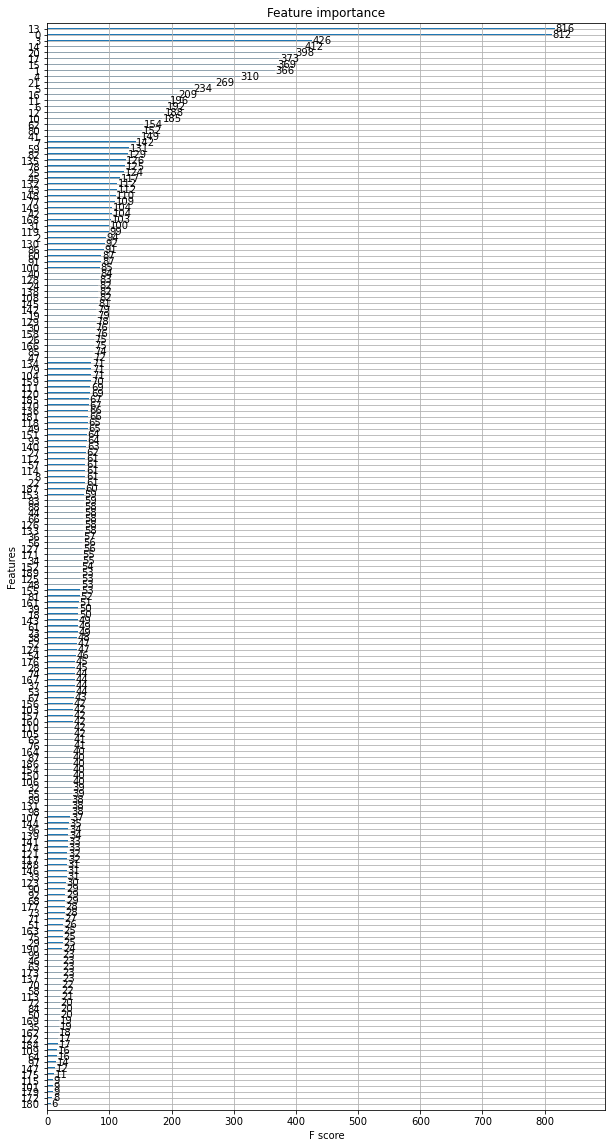

In [180]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 20))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

In [59]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)

In [60]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(rf_clf, threshold='mean')
smf.fit(X_train, y_train)
X_new = smf.transform(X_train)
X_te_new = smf.transform(X_test)
feature_idx = smf.get_support()
feature_name = data.columns[feature_idx]

In [61]:
feature_name

Index([                 'CLNT_ID',                     '총구매액',
                           '구매건수',                    '평균구매액',
                          '최대구매액',                   '주말방문비율',
                         '봄-구매비율',                  '여름-구매비율',
                        '가을-구매비율',                       '월초',
                             '월중',                       '월말',
                '페이지 당 머무른 평균 시간',                   '총 접속시간',
                       '접속한 세션 수',                   '총 검색건수',
                        '평균 검색건수',                '사용 브랜드 개수',
                         '최소 구매액',                '단일상품 최대금액',
       ('CLAC1_NM', '상품 분류명별 개수'), ('CLAC2_NM', '상품 분류명별 개수'),
       ('CLAC3_NM', '상품 분류명별 개수'),               '상품 키워드명 개수',
                           '남성의류',                '속옷/양말/홈웨어',
                          '스포츠패션',                     '여성의류',
                          '유아동의류',                  '출산/육아용품',
                           '패션잡화',                 '화장품

In [89]:
scores = cross_val_score(rf_clf, X_new, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.5118 -1.4564 -1.4705 -1.4626 -1.4535]
평균 검증 정확도: -1.471


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[200],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20],
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1, scoring='neg_log_loss')
grid_cv.fit(X_new, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 점수: {0:.4f}'.format(grid_cv.best_score_))

In [80]:
rf_clf1 = RandomForestClassifier(random_state=0, max_depth=12, min_samples_leaf=18, min_samples_split=8, n_estimators=100)
rf_clf1.fit(X_train, y_train)
pred = pd.DataFrame(rf_clf1.predict_proba(X_test))

In [82]:
scores = cross_val_score(rf_clf1, X_train, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.2988 -1.2935 -1.2937 -1.2927 -1.2964]
평균 검증 정확도: -1.295


In [240]:
# 결과값 정제 및 내보내기
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('이지평.csv',index=False)

In [79]:
X_train = data
X_test = data_te
y_train = cust_tr.LABEL

In [80]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [77]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
lgbm_clf.fit(X_train, y_train)
pred = lgbm_clf.predict(X_test)

LightGBMError: Do not support special JSON characters in feature name.

In [92]:
lgbm_clf.fit(X_new, y_train)

LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64)

In [90]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(lgbm_clf, threshold='mean')
smf.fit(X_train, y_train)
X_new = smf.transform(X_train)
X_te_new = smf.transform(X_test)
feature_idx = smf.get_support()
feature_name = data.columns[feature_idx]

In [91]:
feature_name

Index([                 'CLNT_ID',                     '총구매액',
                           '구매건수',                    '평균구매액',
                          '최대구매액',                   '주말방문비율',
                         '봄-구매비율',                  '여름-구매비율',
                        '가을-구매비율',                       '월초',
                             '월중',                       '월말',
                '페이지 당 머무른 평균 시간',                   '총 접속시간',
                       '접속한 세션 수',                   '총 검색건수',
                        '평균 검색건수',                '사용 브랜드 개수',
                         '최소 구매액',                '단일상품 최대금액',
       ('CLAC1_NM', '상품 분류명별 개수'), ('CLAC2_NM', '상품 분류명별 개수'),
       ('CLAC3_NM', '상품 분류명별 개수'),               '상품 키워드명 개수',
                           '남성의류',                    '스포츠패션',
                           '패션잡화',                 '화장품/뷰티케어',
                         '남성의류상의',                     '메이크업'],
      dtype='object')

In [93]:
scores = cross_val_score(lgbm_clf, X_new, y_train, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.54   -1.4406 -1.4158 -1.4309 -2.3379]
평균 검증 정확도: -1.633


In [87]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60, 100],
         'subsample':[0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=5, n_jobs=-1, scoring='neg_log_loss')
gridcv.fit(X_new, y_train)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
print('최고 예측 점수: {0:.4f}'.format(gridcv.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
최고 예측 점수: -1.3997
